In [1]:
import cantata
from cantata.analysis.quantify import quantify_stimulated, quantify_unstimulated
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cantata.plotting import output as cp
import pandas as pd
from timeit import timeit

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

In [3]:
figsize = (14,5)

batch_size = 32
dt = 1e-3
device = torch.device('cuda')

In [4]:
conf = cantata.config.read('/home/felix/projects/cantata/cantata/configs/1tier.yaml')
conf.pop('_prototypes')
print(conf.to_yaml())

input:
  n_channels: 1
  populations:
    Thal:
      n: 20
      channel: 0
      targets:
        L1:Exc:
          spatial: true
          density: 0.5
          delay: 0.001
          sigma: 0.5
          STDP_frac: 0.0
          A_p: 0.0
          A_d: 0.0
          wmax: 1.0
        L1:Inh:
          spatial: true
          density: 0.5
          delay: 0.001
          sigma: 0.5
          STDP_frac: 0.0
          A_p: 0.0
          A_d: 0.0
          wmax: 1.0
areas:
  L1:
    populations:
      Exc:
        sign: 1
        n: 200
        p: -0.1
        noise_N: 2000
        noise_rate: 8.0
        noise_weight: 0.002
        th_ampl: 0.05
        targets:
          Exc:
            spatial: true
            density: 0.5
            delay: 0.001
            STDP_frac: 1.0
            A_p: 0.2
            A_d: 0.2
            sigma: 0.5
            wmax: 1.0
          Inh:
            spatial: true
            density: 0.5
            delay: 0.001
            sigma: 0.5
        

In [5]:
# Parameters to consider:
conf_options = (
    ('input.populations.Thal.targets.L1:Exc.STDP_frac', [0., 1.]),
    ('input.populations.Thal.targets.L1:Exc.A_p', [.05, .1, .2],
         lambda c: c.input.populations.Thal.targets['L1:Exc'].STDP_frac>0),
    ('input.populations.Thal.targets.L1:Exc.A_d', [.05, .1, .2],
         lambda c: c.input.populations.Thal.targets['L1:Exc'].STDP_frac>0),
    ('input.populations.Thal.targets.L1:Exc.wmax', [.2, .5, 1.]),
    ('input.populations.Thal.targets.L1:Exc.density', [.5, 1.]),
    ('input.populations.Thal.targets.L1:Exc.sigma', [.5, 1.]),
    ('input.populations.Thal.targets.L1:Inh.wmax', [.2, .5, 1.]),
    ('input.populations.Thal.targets.L1:Inh.density', [.5, 1.]),
    ('input.populations.Thal.targets.L1:Inh.sigma', [.5, 1.]),

    ('areas.L1.tau_p', [.01, .02, .04]),
    ('areas.L1.tau_d', [.01, .02, .04]),
    ('areas.L1.populations.Exc.p', [0., -.1, -.2]),
    ('areas.L1.populations.Exc.noise_weight', [.0005, .001, .002]),
    ('areas.L1.populations.Exc.th_ampl', [.05, .1, .2]),
    ('areas.L1.populations.Exc.targets.Exc.density', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Exc.sigma', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Exc.wmax', [.2, .5, 1.]),
    ('areas.L1.populations.Exc.targets.Exc.A_p', [.05, .1, .2]),
    ('areas.L1.populations.Exc.targets.Exc.A_d', [.05, .1, .2]),
    ('areas.L1.populations.Exc.targets.Inh.density', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Inh.sigma', [.2, .5]),
    ('areas.L1.populations.Exc.targets.Inh.wmax', [.2, .5, 1.]),

    ('areas.L1.populations.Inh.noise_weight', [.0005, .001, .002]),
    ('areas.L1.populations.Inh.targets.Exc.density', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Exc.sigma', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Exc.wmax', [.2, .5, 1.]),
    ('areas.L1.populations.Inh.targets.Inh.density', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Inh.sigma', [.2, .5]),
    ('areas.L1.populations.Inh.targets.Inh.wmax', [.2, .5, 1.])
)

In [6]:
def subdict_set(parent, path, value):
    path = path.split('.')
    for key in path[:-1]:
        parent = parent[key]
    parent[path[-1]] = value

def single_configurations(conf, options, sequence = 0):
    conf = conf.copy()
    i = 0
    for entry in options:
        key, values, *condition = entry
        for value in values:
            if i == sequence:
                ret = conf.copy()
                subdict_set(ret, key, value)
                if len(condition) == 0 or condition[0](conf):
                    yield ret, sequence, key, value
                sequence += 1
            i += 1

def combinatorial_configurations(conf, options, seq = 0):
    if len(options) == 1:
        for c,s,k,v in single_configurations(conf, options, seq):
            yield c, s, (k,), (v,)
    else:
        head, tail = options[:1], options[1:]
        tail_length = np.prod([len(entry[1]) for entry in tail])
        for hconf, hseq, hkey, hvalue in combinatorial_configurations(conf, head, seq // tail_length):
            for tconf, tseq, tkey, tvalue in combinatorial_configurations(hconf, tail, seq % tail_length):
                seq = hseq*tail_length + tseq
                yield tconf, seq, (*hkey, *tkey), (*hvalue, *tvalue)
            seq += 1

In [7]:
periods = (int(50e-3/dt), int(50e-3/dt)) # ticks
rates = (0, 50) # Hz

settle, early, late = 5, (10,15), (25,30) # seconds

assert int(1/dt) % sum(periods) == 0

The following takes a while to execute, which is why it's commented out. On Oryx, the times look roughly like this:
- 8 -> 100 s
- 16 -> 110 s
- 32 -> 150 s
- 64 -> 250 s

In [8]:
# for batch_size in [8,16,32,64]:
#     def fn():
#         m = cantata.Conductor(conf, batch_size, dt, shared_weights = False).to(device)
#         with torch.no_grad():
#             r0_u, w0_u, r1_u, w1_u = quantify_unstimulated(m, dt, early=early, late=late)
#             m.reset()
#             r0_s, w0_s, s0, r1_s, w1_s, s1 = quantify_stimulated(
#                 m, periods, rates, dt, settle=settle, early=early, late=late)
#     print(batch_size, timeit(fn, setup='gc.enable()', number=1))

In [9]:
batch_size = 32

In [10]:
m = cantata.Conductor(conf, batch_size, dt, shared_weights = False)
widx = pd.MultiIndex.from_product([
    ['no_stim', 'stim'],
    ['early', 'late'],
    ['time_mean', 'time_std', 'wmean', 'wstd', 'sat_lo', 'sat_hi', *['q'+str(i) for i in range(11)]]
])

ridx = pd.MultiIndex.from_product([
    ['no_stim', 'stim'],
    ['early', 'late'],
    m.areas[0].p_names,
    ['mean', 'std', 'tvar_mean', 'tvar_std', *['q'+str(i) for i in range(11)]]
])

sidx = pd.MultiIndex.from_product([
    ['early', 'late'],
    m.areas[0].p_names,
    ['off', 'on'],
    ['level', 'onset', 'mean', 'std', *['q'+str(i) for i in range(11)]]
])
del m

In [11]:
wdata = pd.DataFrame(index=widx)
rdata = pd.DataFrame(index=ridx)
sdata = pd.DataFrame(index=sidx)

In [12]:
for iconf, seq, key, value in combinatorial_configurations(conf, [
    ('areas.L1.populations.Exc.noise_weight', [0.5e-3, 1e-3, 2e-3, 4e-3, 8e-3]),
    ('areas.L1.populations.Inh.noise_weight', [0.5e-3, 1e-3, 2e-3, 4e-3, 8e-3])
]):
    m = cantata.Conductor(iconf, batch_size, dt, shared_weights = False).to(device)
    with torch.no_grad():
        r0_u, w0_u, r1_u, w1_u = quantify_unstimulated(m, dt, early=early, late=late)
        m.reset()
        r0_s, w0_s, s0, r1_s, w1_s, s1 = quantify_stimulated(
            m, periods, rates, dt, settle=settle, early=early, late=late)
        
    ru = torch.stack((r0_u, r1_u))
    wu = torch.stack((w0_u, w1_u))
    rs = torch.stack((r0_s, r1_s))
    ws = torch.stack((w0_s, w1_s))
    
    wseries = pd.Series(torch.stack((wu, ws)).flatten(), index=widx, name=(seq,key,value))
    rseries = pd.Series(torch.stack((ru, rs)).flatten(), index=ridx, name=(seq,key,value))
    sseries = pd.Series(torch.stack((s0, s1)).flatten(), index=sidx, name=(seq,key,value))
    
    wdata = pd.concat([wdata, wseries], axis=1)
    rdata = pd.concat([rdata, rseries], axis=1)
    sdata = pd.concat([sdata, sseries], axis=1)
    
    print(seq)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [51]:
rdataL = rdata.rename(columns = {c:c[2] for c in rdata.columns}, errors='raise')

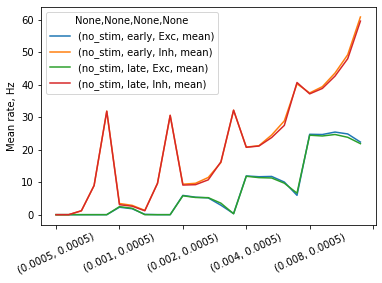

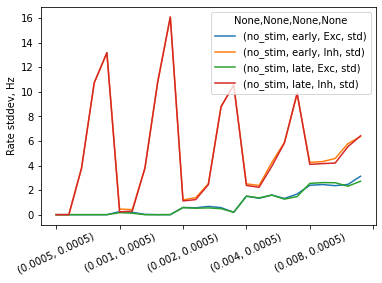

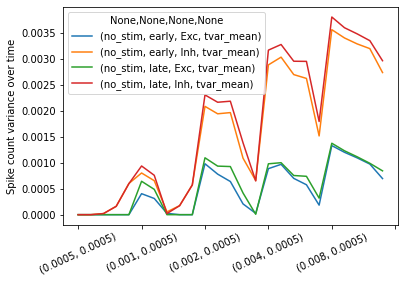

In [63]:
ix = pd.IndexSlice
rdataL.loc[ix['no_stim',:,:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix['no_stim',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix['no_stim',:,:,['tvar_mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Spike count variance over time');

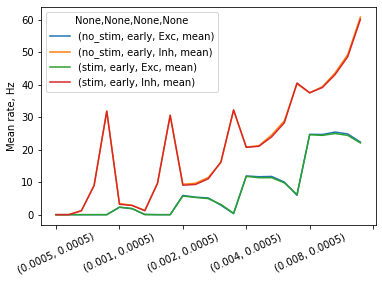

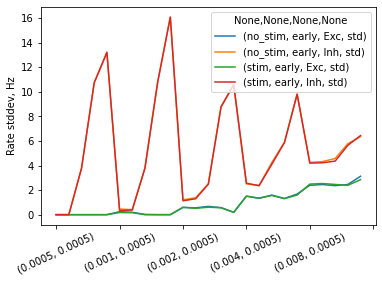

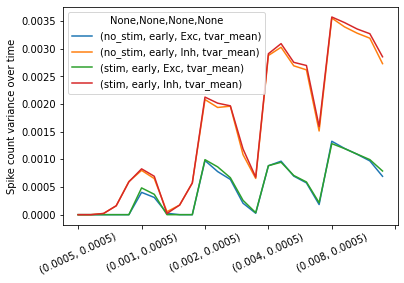

In [65]:
rdataL.loc[ix[:,'early',:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean rate, Hz')
rdataL.loc[ix[:,'early',:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Rate stddev, Hz')
rdataL.loc[ix[:,'early',:,['tvar_mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Spike count variance over time');

In [ ]:
sdataL = sdata.rename(columns = {c:c[2] for c in sdata.columns}, errors='raise')

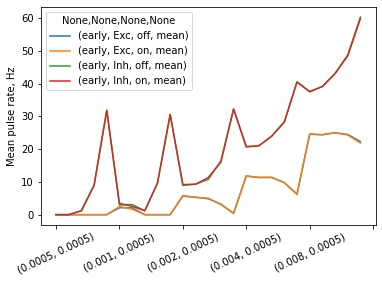

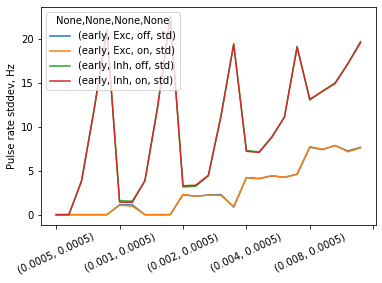

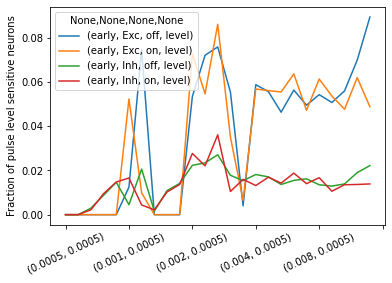

In [68]:
sdataL.loc[ix['early',:,:,['mean']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Mean pulse rate, Hz')
sdataL.loc[ix['early',:,:,['std']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Pulse rate stddev, Hz')
sdataL.loc[ix['early',:,:,['level']], ix[:]].T.plot()
plt.xticks(rotation=25);
plt.ylabel('Fraction of pulse level sensitive neurons');